# Climate Change in Delhi, India

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

In [2]:
# load dataset
file_id = '1c4nA3GQV9zKUxPTprwtyb_8ESjI31oMB'
link='http://drive.google.com/uc?export=download&id={FILE_ID}'
csv_url=link.format(FILE_ID=file_id)

climate_df = pd.read_csv(csv_url)
climate_df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
# check missing value
climate_df.isna().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [4]:
# check data type
climate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [5]:
# change date to datetime type variable
#climate_df['date'] = climate_df['date'].astype('datetime64')
# extract month from date
#climate_df['month'] = climate_df['date'].dt.month.astype(int)

# get four seasons based on month
#def month_to_season(month):
#  if month in [12, 1, 2]:
#    val = 'Winter'
#  elif month in [3, 4, 5]:
#    val = 'Spring'
#  elif month in [6, 7, 8]:
#    val = 'Summer'
#  else:
#    val = 'Fall'
#  return val

#climate_df['season'] = climate_df['month'].apply(month_to_season)

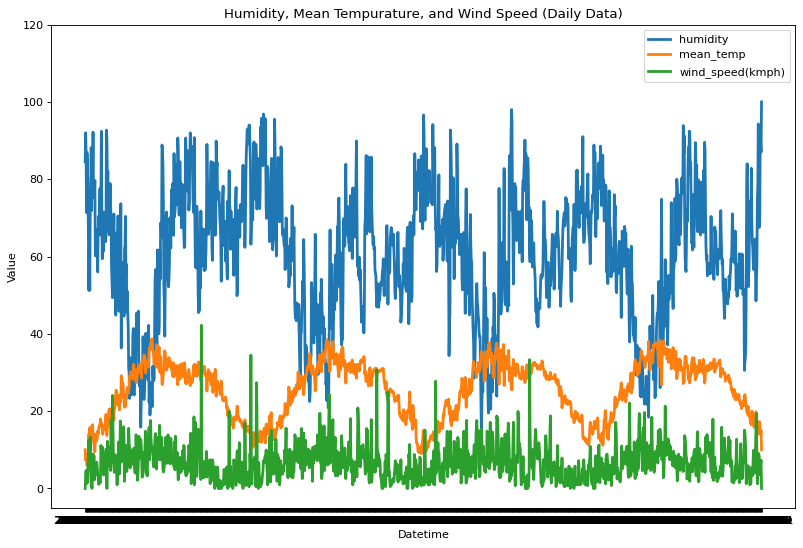

In [6]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)
plt.plot(climate_df['date'],climate_df['humidity'],label='humidity',lw=2.5)
plt.plot(climate_df['date'],climate_df['meantemp'],label='mean_temp',lw=2.5)
plt.plot(climate_df['date'],climate_df['wind_speed'],label='wind_speed(kmph)',lw=2.5)
plt.title('Humidity, Mean Tempurature, and Wind Speed (Daily Data)')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.ylim(-5,120)
plt.legend()
# mean_temp has a clear pattern of change

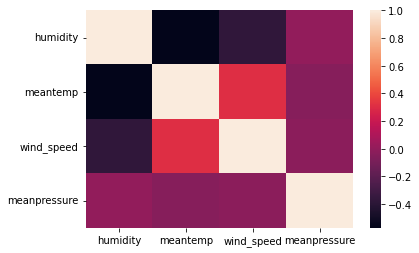

In [7]:
# explore correlation
corr = climate_df[['humidity','meantemp','wind_speed','meanpressure']].corr()
sns.heatmap(corr)

In [8]:
corr

,humidity,meantemp,wind_speed,meanpressure
humidity,1.000000,-0.571951,-0.373972,0.001734
meantemp,-0.571951,1.000000,0.306468,-0.038818
wind_speed,-0.373972,0.306468,1.000000,-0.020670
meanpressure,0.001734,-0.038818,-0.020670,1.000000


# Multivariate Time Series with LSTM Model 

## Preprocessing Data  
- Scale features  
- Prepare for forecast

In [9]:
import plotly.express as px
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf

In [10]:
# one-hot encoding
#from sklearn.preprocessing import OneHotEncoder

#def OneHotEncoding(df, enc, categories):  
#  transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names(categories))
#  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)

#categories = ['month', 'season']
#enc_ohe = OneHotEncoder()
#enc_ohe.fit(climate_df[categories])

#climate_df = OneHotEncoding(climate_df, enc_ohe, categories)

In [11]:
climate_df.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [12]:
# scale features
for i in climate_df.select_dtypes('object').columns:
   le = LabelEncoder().fit(climate_df[i])
   climate_df[i] = le.transform(climate_df[i]) 

validate = climate_df.tail(10)
climate_df.drop(climate_df.tail(10).index,inplace=True)

X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(climate_df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']])
#, 'month_1',
#       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
#       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'season_Fall',
#       'season_Spring', 'season_Summer', 'season_Winter'
Y_data = Y_scaler.fit_transform(climate_df[['humidity']]) 

In [13]:
# preprocesses the data for forecasting
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
     X = []
     y = []
     start = start + window
     if end is None:
         end = len(dataset) - horizon
     for i in range(start, end):
         indices = range(i-window, i)
         X.append(dataset[indices])
         indicey = range(i+1, i+1+horizon)
         y.append(target[indicey])
     return np.array(X), np.array(y)

In [14]:
# allow model to see past 24 days of data and forecast the 10 hrs after data
hist_window = 24
horizon = 10
TRAIN_SPLIT = 1000
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon) 

In [15]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0]) 

Multiple window of past history

[[0.12227074 0.84037162 0.         0.13260331]
 [0.04279476 0.92905405 0.07058266 0.132881  ]
 [0.0356623  0.86993243 0.10974262 0.13299381]
 [0.08151383 0.68468468 0.02921206 0.13279856]
 [0.         0.86796171 0.08763619 0.13271178]
 [0.03056769 0.82027027 0.03505448 0.13290703]
 [0.03056769 0.77060811 0.14921838 0.13316737]
 [0.08733624 0.59459459 0.16918184 0.13300001]
 [0.24454148 0.44721284 0.29606821 0.13277686]
 [0.15283843 0.57432432 0.17527238 0.13260331]
 [0.29694323 0.44763514 0.25038912 0.13266529]
 [0.24454148 0.71621622 0.31332476 0.13259091]
 [0.30058224 0.73001126 0.10974262 0.13229958]
 [0.20887918 0.88372748 0.01460603 0.13253822]
 [0.26637555 0.69087838 0.01251946 0.1326281 ]
 [0.23944687 0.86599099 0.         0.13273348]
 [0.3209607  0.79701577 0.12434865 0.132625  ]
 [0.23944687 0.93102477 0.21198484 0.13245144]
 [0.19868996 0.74774775 0.13934944 0.13338432]
 [0.16157205 0.73141892 0.20064966 0.13320456]
 [0.15895197 0.75168919 0.0

## Split data and build model

In [16]:
# prepare the training data and validation data using tensorflow
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [17]:
from keras.layers import Dropout
#build and compile the model
lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(200,input_shape=x_train.shape[-2:]))
lstm_model.add(tf.keras.layers.Dense(20, activation='tanh'))
lstm_model.add(tf.keras.layers.Dense(20, activation='tanh'))
lstm_model.add(tf.keras.layers.Dense(20, activation='tanh'))
lstm_model.add(tf.keras.layers.Dropout(0.25)),
lstm_model.add(tf.keras.layers.Dense(units=horizon))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               164000    
                                                                 
 dense (Dense)               (None, 20)                4020      
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
Total params: 169,070
Trainable params: 169,070
Non-trai

## Model Evaluation

In [18]:
# configure the model and start training with early stopping and checkpoint 
# early stopping stops training when monitored loss starts increasing above the patience
# checkpoint saves the model weight as it reaches the minimum loss
# out of 30 epochs model stopped training at 14 epochs
model_path = 'LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 
history = lstm_model.fit(train_data,epochs=20,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - 25s 228ms/step - loss: 0.0821 - val_loss: 0.0205
Epoch 2/20
100/100 [==============================] - 21s 211ms/step - loss: 0.0412 - val_loss: 0.0166
Epoch 3/20
100/100 [==============================] - 21s 211ms/step - loss: 0.0329 - val_loss: 0.0165
Epoch 4/20
100/100 [==============================] - 21s 212ms/step - loss: 0.0283 - val_loss: 0.0165
Epoch 5/20
100/100 [==============================] - 22s 219ms/step - loss: 0.0256 - val_loss: 0.0151
Epoch 6/20
100/100 [==============================] - 21s 211ms/step - loss: 0.0237 - val_loss: 0.0152
Epoch 7/20
100/100 [==============================] - 21s 214ms/step - loss: 0.0223 - val_loss: 0.0155
Epoch 8/20
100/100 [==============================] - 21s 212ms/step - loss: 0.0211 - val_loss: 0.0152
Epoch 9/20
100/100 [==============================] - 22s 223ms/step - loss: 0.0201 - val_loss: 0.0175
Epoch 10/20
100/100 [==============================] - 22s 221ms/step - l

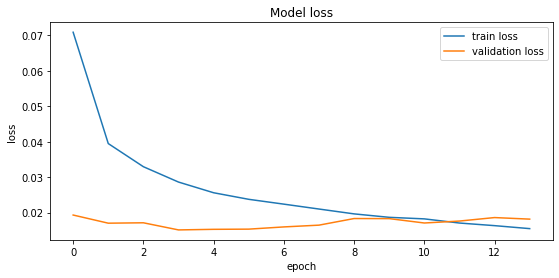

In [ ]:
# the loss curve for training and validation sets
plt.figure(figsize=(9,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

In [ ]:
# evaluate the result with standard performance metrics
data_val = X_scaler.fit_transform(climate_df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].tail(24))
#, 'month_1',
#       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
#       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'season_Fall',
#       'season_Spring', 'season_Summer', 'season_Winter'
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse 

array([[59.687504, 61.15568 , 65.318184, 66.43895 , 65.9696  , 74.64835 ,
        73.38843 , 76.516975, 77.809326, 79.75456 ]], dtype=float32)

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
     def mean_absolute_percentage_error(y_true, y_pred): 
         y_true, y_pred = np.array(y_true), np.array(y_pred)
         return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
     print('Evaluation metric results:-')
     print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
     print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
     print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
     print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
     print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n') 

timeseries_evaluation_metrics_func(validate['humidity'],pred_Inverse[0])

Evaluation metric results:-
MSE is : 236.44873078764363
MAE is : 13.513298387461054
RMSE is : 15.376889503005595
MAPE is : 15.829555047019038
R2 is : -1.126521603509504



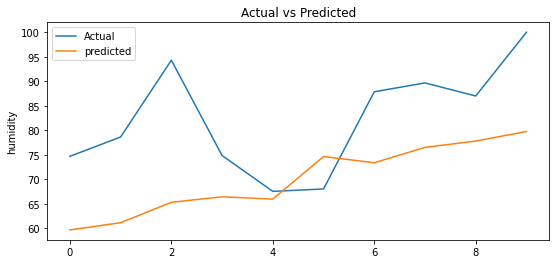

In [ ]:
plt.figure(figsize=(9,4))
plt.plot(list(validate['humidity']))
plt.plot(list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("humidity")
plt.legend(('Actual','predicted'))
plt.show() 